### 選股

In [ ]:
import os
import re
import pandas as pd
from datetime import datetime, timedelta
from collections import defaultdict

class ETFBacktester:
    def __init__(self, folder_path, start_date='2024-06-01', end_date='2025-12-31', switch_frequency=1):
        """
        初始化：
        - folder_path: 放置 daily_stock_summary_YYYY-MM-DD_with_template.xlsx 檔案的資料夾路徑
        - start_date, end_date: 篩選檔案日期範圍 (格式 'YYYY-MM-DD')
        - switch_frequency: 幾天換股一次 (預設 1 表示每日換股)
        """
        self.folder_path = folder_path
        self.start_date = datetime.strptime(start_date, '%Y-%m-%d')
        self.end_date = datetime.strptime(end_date, '%Y-%m-%d')
        self.switch_frequency = switch_frequency  # 現在以天為單位
        self.pattern = r"daily_stock_summary_(\d{4}-\d{2}-\d{2})_with_template\.xlsx"
        self.monthly_results = {}
        self.base = 500000

    def run_backtest(self):
        file_dates = self._read_file_dates()
        print(f'file_dates {len(file_dates)}')
        intervals = self._group_by_interval(file_dates)
        print(f'intervals {len(intervals)}')
        
        for interval in intervals:
            # 若該區間內沒有資料，跳過
            if not interval:
                continue
            # 以該區間第一天作為判斷，檢查是否在指定日期範圍內
            interval_start_date = interval[0][0]
            if not (self.start_date <= interval_start_date <= self.end_date):
                continue

            # 區間買入日：該區間第一筆資料；賣出日：該區間最後一筆資料
            buy_date, buy_file = interval[0]
            sell_date, sell_file = interval[-1]
            
            try:
                buy_df = pd.read_excel(os.path.join(self.folder_path, buy_file), engine='openpyxl')
                print(f'buy_df {buy_df.shape}')
            except Exception as e:
                print(f"Error reading buy file {buy_file}: {e}")
                continue

            try:
                sell_df = pd.read_excel(os.path.join(self.folder_path, sell_file), engine='openpyxl')
            except Exception as e:
                print(f"Error reading sell file {sell_file}: {e}")
                continue
            
            selected_buy_df = self._select_stocks(buy_df)
            if selected_buy_df.empty:
                self.monthly_results[buy_date.strftime('%Y-%m-%d')] = 0
                continue

            merged_df = pd.merge(
                selected_buy_df[['ID', 'Adj Close']],
                sell_df[['ID', 'Adj Close']],
                on='ID',
                suffixes=('_buy', '_sell')
            )

            # 計算獲利 (使用相同公式，這邊依據資料筆數判斷)
            if buy_df.shape[0] == 50:
                merged_df['profit'] = (1 + (merged_df['Adj Close_sell'] - merged_df['Adj Close_buy']) / merged_df['Adj Close_buy']) * self.base/selected_buy_df.shape[0]
            else:
                merged_df['profit'] = (1 + (merged_df['Adj Close_sell'] - merged_df['Adj Close_buy']) / merged_df['Adj Close_buy']) * self.base/selected_buy_df.shape[0]
            period_profit = merged_df['profit'].sum()
            # 使用區間起始日期作為結果標籤
            label = buy_date.strftime('%Y-%m-%d')
            self.monthly_results[label] = (period_profit, period_profit-self.base)
            print(f"區間：{buy_date.strftime('%Y-%m-%d')} ~ {sell_date.strftime('%Y-%m-%d')}，買入日：{buy_date.date()}({buy_file})，賣出日：{sell_date.date()}({sell_file})")
            print(f"   區間獲利：{period_profit-self.base:.2f}({(100*(period_profit-self.base)/period_profit):.2f}%)，總資產：{period_profit:.2f}")
            self.base = period_profit

        return self.monthly_results

    def _read_file_dates(self):
        file_dates = []
        for file in os.listdir(self.folder_path):
            match = re.match(self.pattern, file)
            if match:
                date_str = match.group(1)
                date_obj = datetime.strptime(date_str, '%Y-%m-%d')
                file_dates.append((date_obj, file))
        file_dates.sort(key=lambda x: x[0])
        return file_dates

    def _group_by_interval(self, file_dates):
        """
        依照 switch_frequency（天）分組。
        將 file_dates（已排序）按時間間隔切分，每組內的第一筆為買入日，最後一筆為賣出日。
        """
        intervals = []
        if not file_dates:
            return intervals

        current_interval = [file_dates[0]]
        interval_start = file_dates[0][0]
        for date_obj, file in file_dates[1:]:
            # 若與區間起始日差距小於 switch_frequency 天，加入該區間
            if (date_obj - interval_start).days < self.switch_frequency:
                current_interval.append((date_obj, file))
            else:
                intervals.append(current_interval)
                current_interval = [(date_obj, file)]
                interval_start = date_obj
        if current_interval:
            intervals.append(current_interval)
        return intervals

    def _select_stocks(self, df):
        # df['RRSI'] = df['RSI'].apply(lambda x: x-df.loc[df['ID'] == '0050.TW', 'RSI'].values[0])
        # df = df.loc[df['RRSI'] > 10]
        # df = df.loc[df['ERS_rate_20'] > 94]
        # df = df.loc[df['ERS_rate_50'] > 87]
        # df = df.loc[df['ERS_rate_250'] > 80]
        # df = df.loc[df['year high sort'] == True]
        # df = df.loc[df['Volume 50MA>250k'] == True]
        # df = df.loc[df['business volume(億)'] > 3]
        
        # df = df.loc[df['year low sort'] == True]
        filtered_df = df[
            (df['ERS_rate_250'] > 80) &
            (df['ERS_rate_50'] > 87) &
            (df['ERS_rate_20'] > 94) &
            (df['year high sort'] == True) &
            (df['Volume 50MA>250k'] == True) &
            (df['business volume(億)'] > 3)
        ].copy()
        filtered_df.sort_values('ERS_rate_250', ascending=False, inplace=True)
        print(f'before sort {len(filtered_df)}')
        filtered_df = filtered_df.iloc[:50]
        print(f'after sort {len(filtered_df)}')
        return filtered_df


if __name__ == "__main__":
    folder_path = r"C:\Users\User\Desktop\stock\全個股條件篩選"
    # 此處可修改 switch_frequency 為你想要的天數，例如 10, 30, 45 等
    backtester = ETFBacktester(folder_path, start_date='2019-08-01', end_date='2025-03-01', switch_frequency=90)#2019-04-01
    results = backtester.run_backtest()
    
    total_profit = 0
    for label, profit in results.items():
        print(f"區間起始：{label}，ETF 獲利：{profit[1]}")
        total_profit += profit[1]
    print(f"總獲利：{total_profit-500000:.2f}({(100*(total_profit-500000)/500000):.2f}%)")
    print(f"總資產：{total_profit:.2f}")


file_dates 1393
intervals 24
buy_df (1715, 209)
before sort 17
after sort 17
區間：2019-09-04 ~ 2019-12-02，買入日：2019-09-04(daily_stock_summary_2019-09-04_with_template.xlsx)，賣出日：2019-12-02(daily_stock_summary_2019-12-02_with_template.xlsx)
   區間獲利：7370.88(1.45%)，總資產：507370.88
buy_df (1725, 209)
before sort 11
after sort 11
區間：2019-12-03 ~ 2020-02-27，買入日：2019-12-03(daily_stock_summary_2019-12-03_with_template.xlsx)，賣出日：2020-02-27(daily_stock_summary_2020-02-27_with_template.xlsx)
   區間獲利：8456.69(1.64%)，總資產：515827.58
buy_df (1735, 209)
before sort 22
after sort 22
區間：2020-03-02 ~ 2020-05-29，買入日：2020-03-02(daily_stock_summary_2020-03-02_with_template.xlsx)，賣出日：2020-05-29(daily_stock_summary_2020-05-29_with_template.xlsx)
   區間獲利：185651.80(26.47%)，總資產：701479.37
buy_df (1740, 209)
before sort 18
after sort 18
區間：2020-06-01 ~ 2020-08-28，買入日：2020-06-01(daily_stock_summary_2020-06-01_with_template.xlsx)，賣出日：2020-08-28(daily_stock_summary_2020-08-28_with_template.xlsx)
   區間獲利：191004.55(21.40%)，總資產

   Interval_Start   Total_Asset        Profit  Return (%)  \
0      2019-06-06  5.909901e+05  9.099010e+04   18.198021   
1      2019-09-04  5.997023e+05  9.970234e+04   19.940469   
2      2019-12-03  6.096980e+05  1.096980e+05   21.939597   
3      2020-03-02  8.291347e+05  3.291347e+05   65.826947   
4      2020-06-01  1.054898e+06  5.548983e+05  110.979666   
5      2020-08-31  1.067098e+06  5.670979e+05  113.419576   
6      2020-11-30  1.321652e+06  8.216524e+05  164.330484   
7      2021-03-02  1.541140e+06  1.041140e+06  208.228065   
8      2021-05-31  1.806468e+06  1.306468e+06  261.293621   
9      2021-08-30  1.910547e+06  1.410547e+06  282.109419   
10     2021-11-29  1.840918e+06  1.340918e+06  268.183633   
11     2022-03-01  1.610944e+06  1.110944e+06  222.188701   
12     2022-05-30  1.711162e+06  1.211162e+06  242.232426   
13     2022-08-29  1.550222e+06  1.050222e+06  210.044477   
14     2022-11-28  1.797386e+06  1.297386e+06  259.477238   
15     2023-03-01  2.012

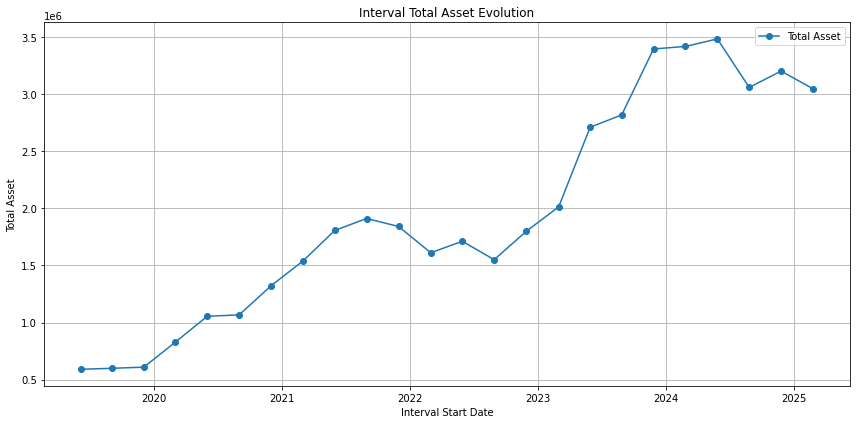

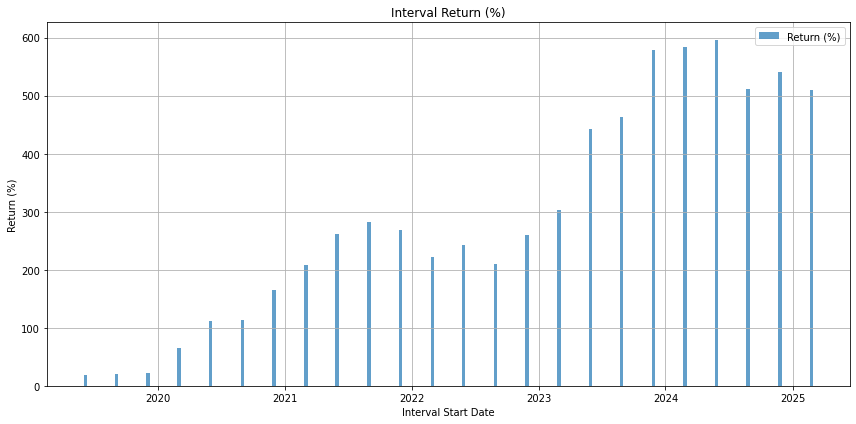

In [5]:
from collections import defaultdict
import matplotlib.pyplot as plt
df_results = pd.DataFrame(list(list(map(lambda x:(x[0], x[1][0]), results.items()))), columns=['Interval_Start', 'Total_Asset'])
# 將日期轉為 datetime 格式
df_results['Interval_Start'] = pd.to_datetime(df_results['Interval_Start'], format='%Y-%m-%d')
df_results.sort_values('Interval_Start', inplace=True)
# 計算區間獲利 (報酬率)
df_results['Profit'] = df_results['Total_Asset'] - 500000
df_results['Return (%)'] = (df_results['Profit'] / 500000) * 100
df_results['Interval Return (%)'] = df_results['Total_Asset'].pct_change() * 100
# 計算累積總資產
df_results['Cumulative_Asset'] = df_results['Total_Asset'].cummax()  # 或依需求計算累積增長

print(df_results)

# 繪圖：折線圖呈現各區間的總資產
plt.figure(figsize=(12,6))
plt.plot(df_results['Interval_Start'], df_results['Total_Asset'], marker='o', label='Total Asset')
plt.xlabel('Interval Start Date')
plt.ylabel('Total Asset')
plt.title('Interval Total Asset Evolution')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 繪圖：區間報酬率
plt.figure(figsize=(12,6))
plt.bar(df_results['Interval_Start'], df_results['Return (%)'], width=10, alpha=0.7, label='Return (%)')
plt.xlabel('Interval Start Date')
plt.ylabel('Return (%)')
plt.title('Interval Return (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

=== 績效數據 ===
初始資產: 526650.37
最終資產: 1349135.06
總報酬率: 56.17%
年化報酬率: 28.25%
最大回撤: -24.23%


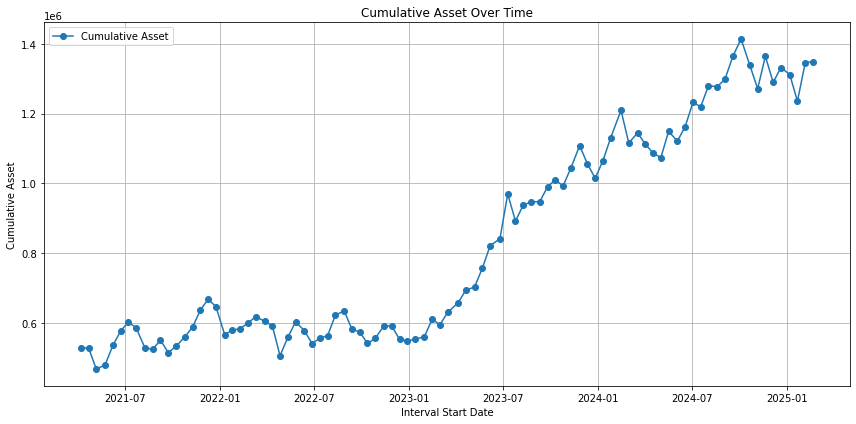

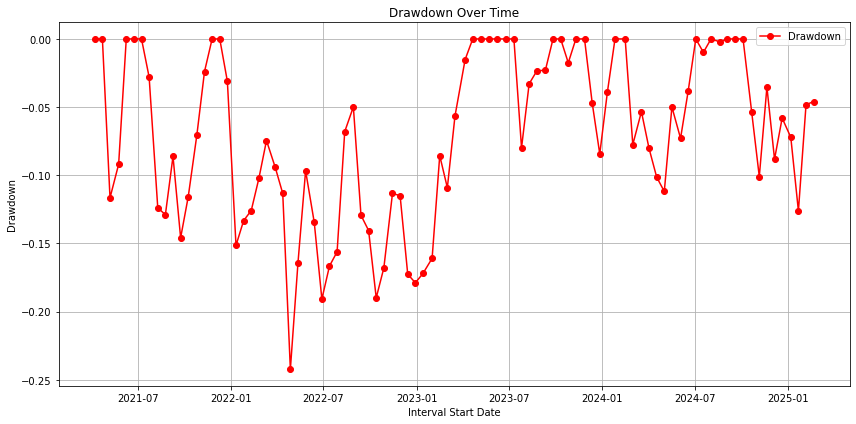

In [56]:
# 假設 df_results 已經包含以下欄位：
# 'Interval_Start'：區間起始日期
# 'Total_Asset'：每個區間結束時的總資產

# 1. 計算累積資產曲線 (如果你希望使用總資產作為累積資產)
df_results = df_results.sort_values('Interval_Start').reset_index(drop=True)
df_results['Cumulative_Asset'] = df_results['Total_Asset']

# 2. 計算最大回撤
# 先計算累積最高資產，再計算每個點的回撤，最後找出最大回撤值
df_results['Peak'] = df_results['Cumulative_Asset'].cummax()
df_results['Drawdown'] = (df_results['Cumulative_Asset'] - df_results['Peak']) / df_results['Peak']
max_drawdown = df_results['Drawdown'].min()  # 注意：這裡回撤為負值

# 3. 計算總報酬率 (以初始資產作為基準)
initial_asset = df_results.loc[0, 'Cumulative_Asset']
final_asset = df_results.loc[len(df_results)-1, 'Cumulative_Asset']
total_return = (final_asset - initial_asset) / initial_asset * 100

# 4. 如果知道每個區間天數，可以計算年化報酬率
# 這裡假設每個區間代表的時間平均為 switch_frequency 天
# 年化天數約為 252 (或 365)，這邊可根據需求調整
import math
avg_days = backtester.switch_frequency  # 平均每區間天數 (簡單假設)
num_intervals = len(df_results)
total_days = num_intervals * avg_days
annualized_return = (final_asset / initial_asset) ** (365/total_days) - 1

# 5. 印出績效數據
print("=== 績效數據 ===")
print(f"初始資產: {initial_asset:.2f}")
print(f"最終資產: {final_asset:.2f}")
print(f"總報酬率: {total_return-100:.2f}%")
print(f"年化報酬率: {annualized_return*100:.2f}%")
print(f"最大回撤: {max_drawdown*100:.2f}%")  # 一般以負數表示回撤

# 6. 繪製累積資產與回撤圖
plt.figure(figsize=(12,6))
plt.plot(df_results['Interval_Start'], df_results['Cumulative_Asset'], marker='o', label='Cumulative Asset')
plt.xlabel('Interval Start Date')
plt.ylabel('Cumulative Asset')
plt.title('Cumulative Asset Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(df_results['Interval_Start'], df_results['Drawdown'], marker='o', color='red', label='Drawdown')
plt.xlabel('Interval Start Date')
plt.ylabel('Drawdown')
plt.title('Drawdown Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [26]:
import os
import re
import pandas as pd
from datetime import datetime
from collections import defaultdict

class ETFBacktester:
    def __init__(self, folder_path, start_date='2024-06-01', end_date='2025-12-31'):
        """
        初始化：
        - folder_path: 放置 daily_stock_summary_YYYY-MM-DD_with_template.xlsx 檔案的資料夾路徑
        """
        self.folder_path = folder_path
        self.start_date = datetime.strptime(start_date, '%Y-%m-%d')
        self.end_date = datetime.strptime(end_date, '%Y-%m-%d')
        # 假設檔案名稱格式如下：daily_stock_summary_2025-03-05_with_template.xlsx
        self.pattern = r"daily_stock_summary_(\d{4}-\d{2}-\d{2})_with_template\.xlsx"
        
        # 用來儲存每個月份的最終獲利結果
        self.monthly_results = {}

    def run_backtest(self):
        """
        執行回測流程：
        1. 讀取並整理所有檔案與對應日期
        2. 依月份分組
        3. 針對每個月份，讀取「第一個交易日」和「最後一個交易日」的檔案
        4. 依照選股條件挑選股票並計算獲利
        5. 回傳每個月份的獲利結果
        """
        file_dates = self._read_file_dates()
        print(f'file_dates {len(file_dates)}')
        monthly_files = self._group_by_month(file_dates)
        print(f'monthly_files {len(monthly_files)}')

        for month, files_list in monthly_files.items():
            month_date = datetime.strptime(month, '%Y-%m')
            if not (self.start_date <= month_date <= self.end_date):
                continue  # 跳過不在範圍內的月份
            # 月初檔案(買入日)與月末檔案(賣出日)
            buy_date, buy_file = files_list[0]
            sell_date, sell_file = files_list[-1]
            
            # 讀取當月「買入日」與「賣出日」的資料
            buy_df = pd.read_excel(os.path.join(self.folder_path, buy_file))
            print(f'buy_df {buy_df.shape}')
            sell_df = pd.read_excel(os.path.join(self.folder_path, sell_file))
            
            # 依選股條件篩選股票 (在買入日)
            selected_buy_df = self._select_stocks(buy_df)

            # 若無符合條件的股票，直接跳過當月
            if selected_buy_df.empty:
                self.monthly_results[month] = 0
                continue

            # 將買入日與賣出日的資料合併 (根據股票代號，假設欄位為 'ID')
            merged_df = pd.merge(
                selected_buy_df[['ID', 'Adj Close']],
                sell_df[['ID', 'Adj Close']],
                on='ID',
                suffixes=('_buy', '_sell')
            )

            # 計算獲利 (單純計算差價，若有需要可乘上張數或股數)
            if buy_df.shape[0] == 50:
                merged_df['profit'] = (1 + (merged_df['Adj Close_sell'] - merged_df['Adj Close_buy']) / merged_df['Adj Close_buy']) * 10000
            else:
                merged_df['profit'] = (1 + (merged_df['Adj Close_sell'] - merged_df['Adj Close_buy']) / merged_df['Adj Close_buy']) * 500000/selected_buy_df.shape[0]
            # 月度總獲利
            monthly_profit = merged_df['profit'].sum()
            self.monthly_results[month] = monthly_profit
            print(f"月份：{month}，ETF 獲利：{monthly_profit}")

        return self.monthly_results

    def _read_file_dates(self):
        """
        讀取資料夾內所有符合命名規則的檔案，擷取日期並排序。
        回傳 [(date_obj, filename), ...]
        """
        file_dates = []
        for file in os.listdir(self.folder_path):
            match = re.match(self.pattern, file)
            if match:
                date_str = match.group(1)  # 例如 '2025-03-05'
                date_obj = datetime.strptime(date_str, '%Y-%m-%d')
                file_dates.append((date_obj, file))
        
        # 依日期排序
        file_dates.sort(key=lambda x: x[0])
        return file_dates

    def _group_by_month(self, file_dates):
        """
        依「年-月」分組，回傳 { 'YYYY-MM': [(date_obj, filename), ...], ... }
        """
        monthly_files = defaultdict(list)
        for date_obj, file in file_dates:
            month_key = date_obj.strftime('%Y-%m')
            monthly_files[month_key].append((date_obj, file))
        return monthly_files

    def _select_stocks(self, df):
        """
        根據選股條件過濾股票：
        1. ERS_rate_250 > 90
        2. year_high_sort == True
        3. Volume_50MA > 250000 (250k)
        4. business_volume(億) > 3
        假設對應的欄位名稱為：
          - 'ERS_rate_250'
          - 'year_high_sort'
          - 'Volume_50MA'
          - 'business_volume(億)'
        依實際檔案欄位名稱調整。
        """
        filtered_df = df[
            (df['ERS_rate_250'] > 90) &
            (df['year high sort'] == True) &
            (df['Volume 50MA>250k'] == True) &
            (df['business volume(億)'] > 3)
        ].copy()
        filtered_df.sort_values('ERS_rate_250', ascending=False, inplace=True)
        print(f'before sort {len(filtered_df)}')
        filtered_df = filtered_df.iloc[:50]
        print(f'after sort {len(filtered_df)}')
        return filtered_df


if __name__ == "__main__":
    # 使用範例：請將 'your_folder_path' 改為實際資料夾路徑
    folder_path = r"C:\Users\User\Desktop\stock\全個股條件篩選"
    
    # 建立回測物件
    backtester = ETFBacktester(folder_path, start_date = '2023-01-01', end_date='2024-06-30')
    
    # 執行回測
    results = backtester.run_backtest()
    
    # 查看結果
    total_profit = 0
    for month, profit in results.items():
        print(f"月份：{month}，ETF 獲利：{profit}")
        total_profit += profit-500000
    print(f"總獲利：{total_profit}")

file_dates 1393
monthly_files 70
buy_df (1816, 209)
before sort 35
after sort 35
月份：2023-01，ETF 獲利：523987.960963087
buy_df (1816, 209)
before sort 58
after sort 50
月份：2023-02，ETF 獲利：548788.3189854348
buy_df (1817, 209)
before sort 49
after sort 49
月份：2023-03，ETF 獲利：516439.2612210967
buy_df (1819, 209)
before sort 58
after sort 50
月份：2023-04，ETF 獲利：521859.7828838249
buy_df (1819, 209)
before sort 67
after sort 50
月份：2023-05，ETF 獲利：513146.621793574
buy_df (1820, 209)
before sort 75
after sort 50
月份：2023-06，ETF 獲利：551303.0999783071
buy_df (1824, 209)
before sort 77
after sort 50
月份：2023-07，ETF 獲利：522424.73437594186
buy_df (1824, 209)
before sort 63
after sort 50
月份：2023-08，ETF 獲利：497399.49384359154
buy_df (1826, 209)
before sort 55
after sort 50
月份：2023-09，ETF 獲利：492647.76258747984
buy_df (1828, 209)
before sort 66
after sort 50
月份：2023-10，ETF 獲利：450114.1462323292
buy_df (1832, 209)
before sort 47
after sort 47
月份：2023-11，ETF 獲利：554266.9158163832


OptionError: No such keys(s): 'io.excel.zip.reader'

In [ ]:
import os
import re
import pandas as pd
from datetime import datetime
from collections import defaultdict

class ETFBacktester:
    def __init__(self, folder_path, start_date, end_date):
        """
        初始化：
        - folder_path: 儲存每日 Excel 資料的資料夾
        - start_date, end_date: 限制回測範圍，格式為 'YYYY-MM'
        """
        self.folder_path = folder_path
        self.start_date = datetime.strptime(start_date, '%Y-%m')
        self.end_date = datetime.strptime(end_date, '%Y-%m')
        self.pattern = r"daily_stock_summary_(\d{4}-\d{2}-\d{2})_with_template\.xlsx"
        
        # 存儲結果
        self.monthly_results = {}
        self.monthly_0050 = {}  # 0050.TW 的單月獲利

    def run_backtest(self):
        """
        執行回測：
        1. 讀取並整理所有檔案
        2. 依月份篩選
        3. 進行回測（選股 + 0050.TW 獲利計算）
        """
        file_dates = self._read_file_dates()
        monthly_files = self._group_by_month(file_dates)

        for month, files_list in monthly_files.items():
            month_date = datetime.strptime(month, '%Y-%m')
            if not (self.start_date <= month_date <= self.end_date):
                continue  # 跳過不在範圍內的月份
            
            # 取得月初、月末檔案
            buy_date, buy_file = files_list[0]
            sell_date, sell_file = files_list[-1]

            # 讀取 Excel 檔案
            buy_df = pd.read_excel(os.path.join(self.folder_path, buy_file))
            sell_df = pd.read_excel(os.path.join(self.folder_path, sell_file))

            # 篩選符合條件的股票
            selected_buy_df = self._select_stocks(buy_df)

            # 處理 ETF 0050.TW
            profit_0050 = self._calculate_0050_profit(buy_df, sell_df)

            # 記錄 0050.TW 獲利
            self.monthly_0050[month] = profit_0050

            # 若無符合條件的股票，則當月 ETF 獲利為 0
            if selected_buy_df.empty:
                self.monthly_results[month] = 0
                continue

            # 計算 ETF 投資組合的總獲利
            monthly_profit = self._calculate_etf_profit(selected_buy_df, sell_df)
            self.monthly_results[month] = monthly_profit

        return self.monthly_results, self.monthly_0050

    def _read_file_dates(self):
        """
        讀取資料夾內符合命名規則的檔案，擷取日期並排序。
        回傳 [(date_obj, filename), ...]
        """
        file_dates = []
        for file in os.listdir(self.folder_path):
            match = re.match(self.pattern, file)
            if match:
                date_str = match.group(1)  # '2025-03-05'
                date_obj = datetime.strptime(date_str, '%Y-%m-%d')
                file_dates.append((date_obj, file))
        
        # 依日期排序
        file_dates.sort(key=lambda x: x[0])
        return file_dates

    def _group_by_month(self, file_dates):
        """
        依月份分組，回傳 {'YYYY-MM': [(date_obj, filename), ...]}
        """
        monthly_files = defaultdict(list)
        for date_obj, file in file_dates:
            month_key = date_obj.strftime('%Y-%m')
            monthly_files[month_key].append((date_obj, file))
        return monthly_files

    def _select_stocks(self, df):
        """
        根據選股條件過濾股票：
        - ERS_rate_250 > 90
        - year_high_sort == True
        - Volume_50MA > 250000
        - business_volume(億) > 3
        """
        return df[
            (df['ERS_rate_250'] > 90) &
            (df['year_high_sort'] == True) &
            (df['Volume_50MA'] > 250000) &
            (df['business_volume(億)'] > 3)
        ].copy()

    def _calculate_0050_profit(self, buy_df, sell_df):
        """
        計算 0050.TW 的月度獲利。
        """
        buy_price = buy_df.loc[buy_df['ID'] == '0050.TW', 'Adj Close']
        sell_price = sell_df.loc[sell_df['ID'] == '0050.TW', 'Adj Close']

        if buy_price.empty or sell_price.empty:
            return 0  # 若 0050.TW 當月無數據，則獲利為 0
        
        return float(sell_price.values[0] - buy_price.values[0])

    def _calculate_etf_profit(self, buy_df, sell_df):
        """
        計算 ETF 投資組合的月度總獲利。
        """
        merged_df = pd.merge(
            buy_df[['ID', 'Adj Close']],
            sell_df[['ID', 'Adj Close']],
            on='ID',
            suffixes=('_buy', '_sell')
        )
        merged_df['profit'] = merged_df['Adj Close_sell'] - merged_df['Adj Close_buy']
        return merged_df['profit'].sum()


if __name__ == "__main__":
    # 設定資料夾與回測區間
    folder_path = "your_folder_path"  # 設定你的資料夾路徑
    start_date = "2024-01"  # 設定起始月份 (YYYY-MM)
    end_date = "2025-12"  # 設定結束月份 (YYYY-MM)
    
    # 建立回測物件
    backtester = ETFBacktester(folder_path, start_date, end_date)
    
    # 執行回測
    results, results_0050 = backtester.run_backtest()

    # 顯示結果
    print("\n--- ETF 回測結果 ---")
    for month, profit in results.items():
        print(f"月份：{month}，ETF 獲利：{profit:.2f}，0050.TW 獲利：{results_0050[month]:.2f}")
